Thanh Truc Bui

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

import pickle # save model

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


<font size="5">Read the protein mass table</font>

In [2]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [3]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [4]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
#enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from prott5 embeddings</font>

In [5]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [6]:
def PCA_for_emb(emb:list,n:int):   #Reducing the embedding vector to n dimensions
    pca = PCA(n_components=n)
    emb_pca = pca.fit_transform(emb)
    return emb_pca


In [7]:

def read_prott5(path_to_prott5:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_prott5) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb)[0], dtype=float)
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map


enzymes_map = read_prott5(os.getenv("PROTT5_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_prott5(os.getenv("PROTT5_NON_ENZYMES"),non_enzymes_map)


In [ ]:
#enzymes_split100_map = read_esm2("/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/split100_esm2_3b.h5",enzymes_split100_map)


Pick the best n for the PCA

In [8]:
embs_enzymes=[]
embs_non_enzymes=[]

for protein in enzymes_map.keys():
    embs_enzymes.append(enzymes_map[protein].embeddings)
for protein in non_enzymes_map.copy():
    if non_enzymes_map[protein].embeddings is None:
        non_enzymes_map.pop(protein)
    else:
        embs_non_enzymes.append(non_enzymes_map[protein].embeddings)

    


In [9]:
print(len(embs_non_enzymes))
print(len(non_enzymes_map))

39495
39495


In [ ]:
#embs_non_enzymes.pop(3393)

In [10]:

def pick_n_for_pca(embs):
    pca = PCA().fit(embs)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 1025, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks([256,300,380, 420, 512,1024])    
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()


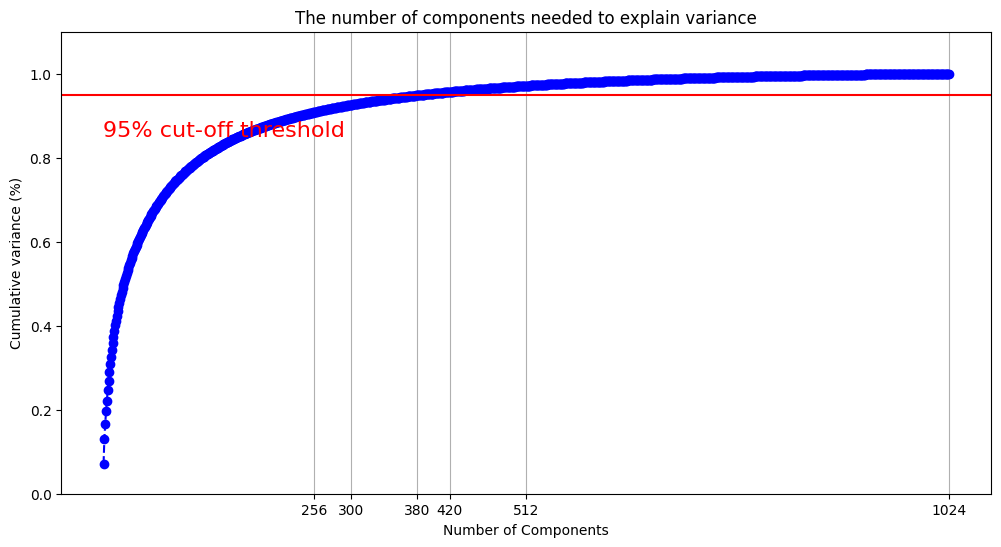

In [11]:

pick_n_for_pca(embs_enzymes)

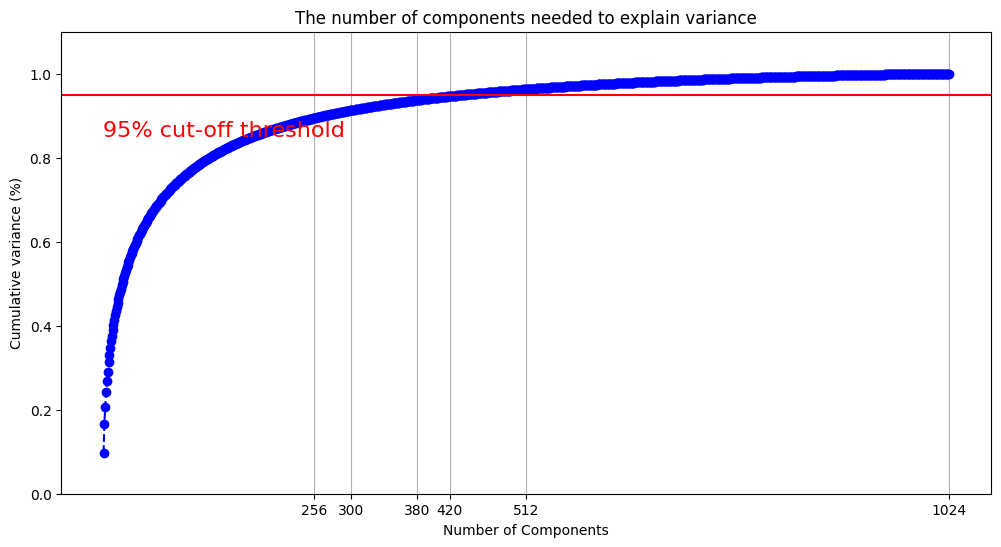

In [12]:
pick_n_for_pca(embs_non_enzymes)

Now that with n=420 we get 95% cut off, we choose PCA with 420 dimension

<font size="5">Create a dataframe<font>

In [28]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        
    emb_pca_all=PCA_for_emb(np.array(embs),420).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [29]:

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


       Label       Entry        Mass  \
0          1  A0A024RBG1   20403.292   
1          1  A0A024SMV2   42741.490   
2          1  A0A060S684   63631.543   
3          1  A0A075TXZ3   61430.846   
4          1  A0A077K8G3   45202.778   
...      ...         ...         ...   
48694      0      X2JAU8  117164.590   
48695      0      X5HYT8   46670.171   
48696      0      X5LX76  118226.070   
48697      0      X6R8D5   14504.182   
48698      0      X6R8R1   52161.639   

                                                     Emb  Emb median  \
0      [0.058135986328125, -0.0034160614013671875, 0....   -0.001328   
1      [0.031951904296875, 0.0275726318359375, 0.0469...   -0.001235   
2      [0.045440673828125, 0.0222015380859375, 0.0151...   -0.000760   
3      [0.044189453125, 0.00945281982421875, 0.031646...   -0.000352   
4      [0.0233001708984375, -0.002689361572265625, -0...    0.000797   
...                                                  ...         ...   
48694  [0.00204

In [30]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_prott5_df.csv', index = False)

In [31]:
df

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
1,1,A0A024SMV2,42741.490,"[0.031951904296875, 0.0275726318359375, 0.0469...",-0.001235,0.035216,1.128369,"[-0.17373749055841664, -0.14632181382256038, -..."
2,1,A0A060S684,63631.543,"[0.045440673828125, 0.0222015380859375, 0.0151...",-0.000760,0.037363,1.195616,"[-0.04689713470124111, -0.08482406364375604, -..."
3,1,A0A075TXZ3,61430.846,"[0.044189453125, 0.00945281982421875, 0.031646...",-0.000352,0.036913,1.181245,"[-0.0837954618025697, -0.11456956791347762, 0...."
4,1,A0A077K8G3,45202.778,"[0.0233001708984375, -0.002689361572265625, -0...",0.000797,0.039896,1.276834,"[-0.15241968732257236, 0.2537490199030772, 0.1..."
...,...,...,...,...,...,...,...,...
48694,0,X2JAU8,117164.590,"[0.002048492431640625, -0.0240020751953125, 0....",0.000184,0.039975,1.279353,"[-0.22531574142995112, -0.19353577488080842, 0..."
48695,0,X5HYT8,46670.171,"[0.0134735107421875, 0.0019464492797851562, 0....",-0.000730,0.045236,1.447548,"[-0.18585127306481608, -0.11325464450245966, 0..."
48696,0,X5LX76,118226.070,"[-0.01490020751953125, -0.021697998046875, 0.0...",0.000694,0.040632,1.300643,"[-0.10307539629680945, -0.31751500761234014, -..."
48697,0,X6R8D5,14504.182,"[0.019012451171875, 0.0225982666015625, -0.000...",0.002801,0.046701,1.496904,"[0.19855280225809716, 0.021408436100297107, 0...."


PCA -> df

In [32]:
df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_prott5_df.csv')

In [33]:
enzymes_df_dup=enzymes_df.loc[enzymes_df.index.repeat(4)].reset_index(drop=True)
enzymes_df_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
1,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
2,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
3,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
4,1,A0A024SMV2,42741.490,"[0.031951904296875, 0.0275726318359375, 0.0469...",-0.001235,0.035216,1.128369,"[-0.17373749055841664, -0.14632181382256038, -..."
...,...,...,...,...,...,...,...,...
36811,1,W8QRE4,55422.596,"[0.0111083984375, 0.0181121826171875, 0.017471...",-0.000775,0.031466,1.006972,"[-0.2311396018332343, -0.15708593734021936, 0...."
36812,1,X1WBB5,31128.858,"[0.0203399658203125, -0.0197906494140625, -0.0...",0.002899,0.037192,1.191638,"[0.15423860247210186, 0.003965196884179363, 0...."
36813,1,X1WBB5,31128.858,"[0.0203399658203125, -0.0197906494140625, -0.0...",0.002899,0.037192,1.191638,"[0.15423860247210186, 0.003965196884179363, 0...."
36814,1,X1WBB5,31128.858,"[0.0203399658203125, -0.0197906494140625, -0.0...",0.002899,0.037192,1.191638,"[0.15423860247210186, 0.003965196884179363, 0...."


In [34]:
df_with_enzyme_dup=pd.concat([enzymes_df_dup,non_enzymes_df,],axis=0)
df_with_enzyme_dup=df_with_enzyme_dup.reset_index(drop=True)
df_with_enzyme_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
1,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
2,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
3,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
4,1,A0A024SMV2,42741.490,"[0.031951904296875, 0.0275726318359375, 0.0469...",-0.001235,0.035216,1.128369,"[-0.17373749055841664, -0.14632181382256038, -..."
...,...,...,...,...,...,...,...,...
76306,0,X2JAU8,117164.590,"[0.002048492431640625, -0.0240020751953125, 0....",0.000184,0.039975,1.279353,"[-0.22531574142995112, -0.19353577488080842, 0..."
76307,0,X5HYT8,46670.171,"[0.0134735107421875, 0.0019464492797851562, 0....",-0.000730,0.045236,1.447548,"[-0.18585127306481608, -0.11325464450245966, 0..."
76308,0,X5LX76,118226.070,"[-0.01490020751953125, -0.021697998046875, 0.0...",0.000694,0.040632,1.300643,"[-0.10307539629680945, -0.31751500761234014, -..."
76309,0,X6R8D5,14504.182,"[0.019012451171875, 0.0225982666015625, -0.000...",0.002801,0.046701,1.496904,"[0.19855280225809716, 0.021408436100297107, 0...."


In [35]:
df_with_enzyme_dup.to_csv(r'/home/trucbui/PBLGit/random_forest/split30dup__and_non_enzymes_with_prott5_df.csv', index = False)

In [25]:
df_with_enzyme_dup=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/split30dup__and_non_enzymes_with_prott5_df.csv')

In [36]:
df_with_enzyme_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
1,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
2,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
3,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0..."
4,1,A0A024SMV2,42741.490,"[0.031951904296875, 0.0275726318359375, 0.0469...",-0.001235,0.035216,1.128369,"[-0.17373749055841664, -0.14632181382256038, -..."
...,...,...,...,...,...,...,...,...
76306,0,X2JAU8,117164.590,"[0.002048492431640625, -0.0240020751953125, 0....",0.000184,0.039975,1.279353,"[-0.22531574142995112, -0.19353577488080842, 0..."
76307,0,X5HYT8,46670.171,"[0.0134735107421875, 0.0019464492797851562, 0....",-0.000730,0.045236,1.447548,"[-0.18585127306481608, -0.11325464450245966, 0..."
76308,0,X5LX76,118226.070,"[-0.01490020751953125, -0.021697998046875, 0.0...",0.000694,0.040632,1.300643,"[-0.10307539629680945, -0.31751500761234014, -..."
76309,0,X6R8D5,14504.182,"[0.019012451171875, 0.0225982666015625, -0.000...",0.002801,0.046701,1.496904,"[0.19855280225809716, 0.021408436100297107, 0...."


In [37]:
for i in range(420):
    df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
df_with_enzyme_dup


/tmp/ipykernel_11809/3748904097.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_11809/3748904097.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_11809/3748904097.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,PCA 2,...,PCA 411,PCA 412,PCA 413,PCA 414,PCA 415,PCA 416,PCA 417,PCA 418,PCA 419,PCA 420
0,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0...",-0.500743,0.123773,...,0.002443,0.009691,0.001376,0.009043,0.006317,-0.020703,0.000891,-0.006631,-0.005804,0.019876
1,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0...",-0.500743,0.123773,...,0.002443,0.009691,0.001376,0.009043,0.006317,-0.020703,0.000891,-0.006631,-0.005804,0.019876
2,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0...",-0.500743,0.123773,...,0.002443,0.009691,0.001376,0.009043,0.006317,-0.020703,0.000891,-0.006631,-0.005804,0.019876
3,1,A0A024RBG1,20403.292,"[0.058135986328125, -0.0034160614013671875, 0....",-0.001328,0.034692,1.110318,"[-0.5007430052390056, 0.12377297812169945, 0.0...",-0.500743,0.123773,...,0.002443,0.009691,0.001376,0.009043,0.006317,-0.020703,0.000891,-0.006631,-0.005804,0.019876
4,1,A0A024SMV2,42741.490,"[0.031951904296875, 0.0275726318359375, 0.0469...",-0.001235,0.035216,1.128369,"[-0.17373749055841664, -0.14632181382256038, -...",-0.173737,-0.146322,...,0.007911,0.022550,-0.006161,-0.003611,0.005396,0.009458,0.020214,0.009083,-0.009795,-0.007169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76306,0,X2JAU8,117164.590,"[0.002048492431640625, -0.0240020751953125, 0....",0.000184,0.039975,1.279353,"[-0.22531574142995112, -0.19353577488080842, 0...",-0.225316,-0.193536,...,0.012646,-0.016775,-0.008019,0.002613,0.008415,0.006172,0.006664,-0.006238,0.010112,-0.007865
76307,0,X5HYT8,46670.171,"[0.0134735107421875, 0.0019464492797851562, 0....",-0.000730,0.045236,1.447548,"[-0.18585127306481608, -0.11325464450245966, 0...",-0.185851,-0.113255,...,0.006847,0.025206,0.010296,-0.011926,0.010285,0.004699,0.016438,-0.003637,-0.009088,0.020206
76308,0,X5LX76,118226.070,"[-0.01490020751953125, -0.021697998046875, 0.0...",0.000694,0.040632,1.300643,"[-0.10307539629680945, -0.31751500761234014, -...",-0.103075,-0.317515,...,0.000555,-0.016494,0.002520,-0.010774,0.007631,0.010147,0.001833,0.015372,0.006712,0.019851
76309,0,X6R8D5,14504.182,"[0.019012451171875, 0.0225982666015625, -0.000...",0.002801,0.046701,1.496904,"[0.19855280225809716, 0.021408436100297107, 0....",0.198553,0.021408,...,0.017935,0.007663,0.028080,-0.005980,-0.013470,0.008346,-0.007546,0.021939,0.006173,0.002283


<font size="5">Train the model</font>

In [38]:
#Define the features and output:
y = df_with_enzyme_dup['Label']
# use 700 PCA components, mass and Emb magnitude as features 
X = df_with_enzyme_dup.drop(['Label','Entry','Emb', 'Emb median','Emb std','Emb PCA'],axis=1)
#X = df_with_enzyme_dup[['Mass', 'Emb std']]

#Split data into train an test, with test size of 33%%:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)


In [39]:

#Build the model:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=8,n_estimators=100)
rf.fit(X_train, y_train)
y_pred=rf.predict(X)

<font size="5">Evaluate the model</font>

accuracy on training set: 0.964129
accuracy on test set: 0.948974
F1 score: 0.9583461317592381
MCC score: 0.9187394768368298


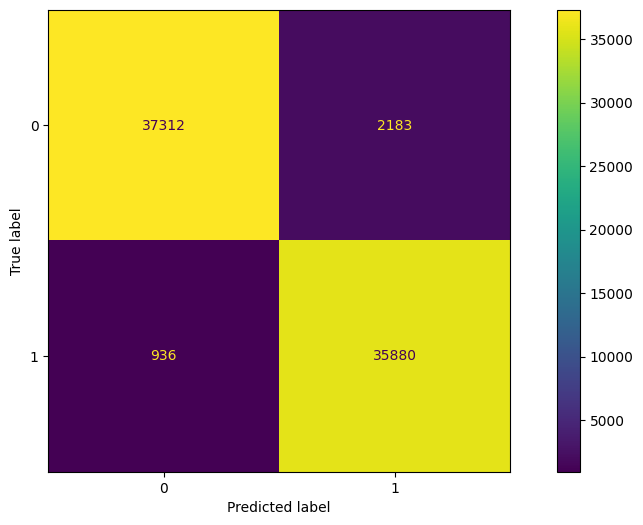

In [40]:
cm=confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
print("accuracy on training set: %f" % rf.score(X_train, y_train))
print("accuracy on test set: %f" % rf.score(X_test, y_test))
f1 = f1_score(y, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y, y_pred)
print('MCC score:', mcc_score)


<font size="5">Make a tree</font>

In [41]:
tree = rf.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file:
graph.write_png('tree_rf_prott5.png')

<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.9914524735726101


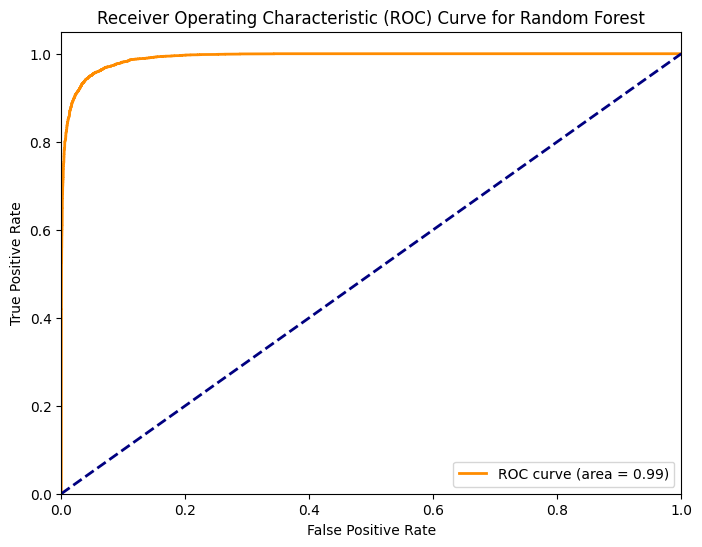

In [42]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

<font size="5">Save the model</font>

In [43]:
# save the model to disk
pickle.dump(rf , open(r'/home/trucbui/PBLGit/random_forest/random_forest_prott5.pk1' , 'wb'))

# load the model from disk
loaded_model = pickle.load(open(r'/home/trucbui/PBLGit/random_forest/random_forest_prott5.pk1' , 'rb'))

loaded_model_accuracy = loaded_model.score(X_test, y_test)

print("Loaded Model Accuracy:" , loaded_model_accuracy * 100 , "%")




Loaded Model Accuracy: 94.897351387841 %
